### Problem 9.1 : Applying QSVM with PennyLane Circle Dataset

PennyLane is an open-source software framework for quantum machine learning, quantum chemistry, and quantum computing, with the ability to run on all hardware.

Link - https://pennylane.ai/datasets/


In [1]:
# !pip install pennylane
# !pip install pennylane --upgrade

In [2]:
import pennylane as qml
import numpy as np

from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [3]:
def generate_circle_data(n_samples=100, noise=0.1):
    # Generate circle dataset
    phi = 2 * np.pi * np.random.random(n_samples)
    r = np.random.random(n_samples)
    
    X = np.zeros((n_samples, 2))
    X[:, 0] = r * np.cos(phi)
    X[:, 1] = r * np.sin(phi)
    
    y = 2 * (r > 0.5) - 1
    
    if noise > 0:
        X += noise * np.random.randn(*X.shape)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, X

"""
The data generation now creates:

- Inner circle (labeled -1)
- Outer circle (labeled 1)
- Adjustable noise level
- Scaled features for better QSVM performance
"""

'\nThe data generation now creates:\n\n- Inner circle (labeled -1)\n- Outer circle (labeled 1)\n- Adjustable noise level\n- Scaled features for better QSVM performance\n'

In [4]:
def visualize_data(X, y, title="Circle Dataset"):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', marker='o', label='Class 1', alpha=0.6)
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='r', marker='x', label='Class -1', alpha=0.6)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def create_and_train_qsvm(X_train, X_test, y_train):
    # Create quantum kernel
    feature_map = ZZFeatureMap(feature_dimension=2, reps=3, entanglement='full')
    
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

    # Compute kernel matrices
    print("Computing kernel matrices...")
    
    # Kernel matrix for training data
    kernel_matrix_train = quantum_kernel.evaluate(X_train)
    
    # Kernel matrix for test data against training data
    kernel_matrix_test = quantum_kernel.evaluate(X_test)

    # Train SVM
    from sklearn.svm import SVC
    svm = SVC(kernel='precomputed')
    
    # Fit SVM with the training kernel matrix
    svm.fit(kernel_matrix_train, y_train)

    # Make predictions using the test kernel matrix
    y_pred = svm.predict(kernel_matrix_test)
    
    return y_pred


In [6]:
print("Generating circle dataset...")
X_scaled, y, X_original = generate_circle_data(n_samples=100, noise=0.1)


Generating circle dataset...



Visualizing dataset...


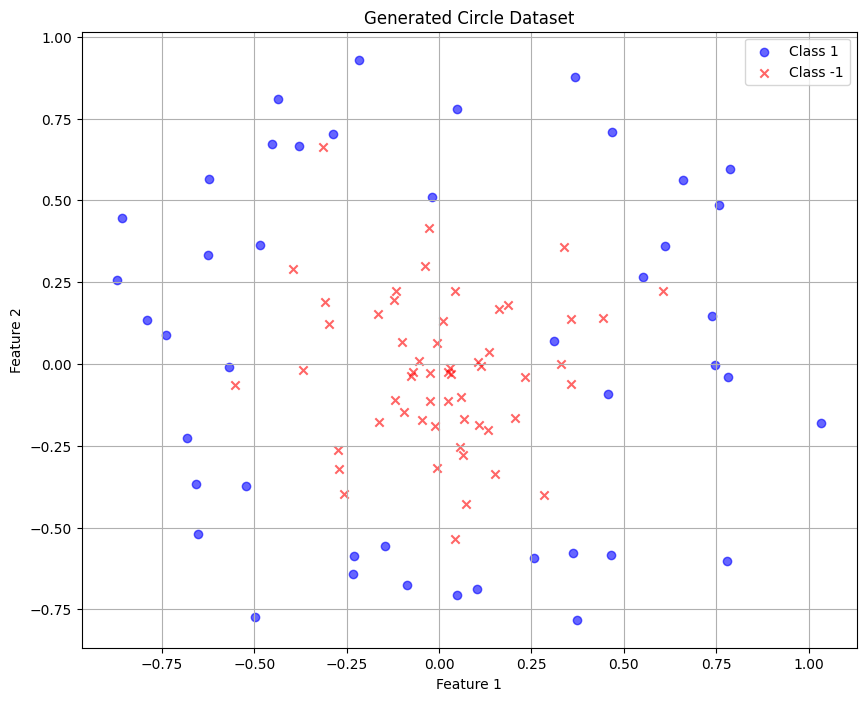

In [7]:
print("\nVisualizing dataset...")
visualize_data(X_original, y, "Generated Circle Dataset")

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [9]:
print("\nTraining QSVM...")
y_pred = create_and_train_qsvm(X_train, X_test, y_train)

print("\nResults:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training QSVM...
Computing kernel matrices...


ValueError: X has 30 features, but SVC is expecting 70 features as input.